In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.datasets import make_circles
import tensorflow as tf

(1500, 2) (1500,)
(2, 1500) (1, 1500)


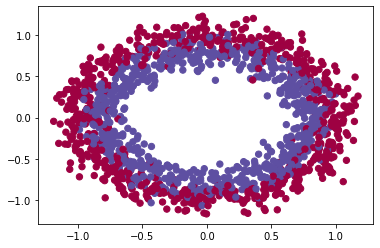

In [97]:
X ,Y = make_circles(n_samples=1500, shuffle=True, noise=0.1, random_state=0)
print(X.shape,Y.shape)
X = X.T
Y = Y.reshape(1,Y.shape[0])
print(X.shape , Y.shape)
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [98]:
def layer_dims(data, labels):
  n_x = data.shape[0]
  n_h = 4
  n_y = labels.shape[0]
  return (n_x , n_h , n_y)

n_x , n_h , n_y = layer_dims(X , Y)
print("The size of the input layer is: n_x = " + str(n_x)) 
print("The size of the hidden layer is: n_h = " + str(n_h)) 
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 1


In [137]:
def initialize_parameters(layers_dims):
  np.random.seed(3)
  L = len(layers_dims) - 1 
  parameters = {}
  for l in range(1, L + 1):
        # The weight parameter is calculated based on (no.of neurons in current layer , no.of neurons in previous layer)
        # In the weight calculation then "He Initialization" is used which used to improve the initialization
        # The "He Initialization " is similar to "Xavier initialization" where except sqrt(1./layers_dims[l-1]) we use sqrt(2./layers_dims[l-1]) 
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(np.divide(2,layers_dims[l-1]))
        # The bias parameter is initialised with zeros with dimension of (layer_dims[l] , 1) where 'l' is the current layer.
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
        
  return parameters

parameters = initialize_parameters([2,4,4,1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("W3 = " + str(parameters["W3"]))
print("b2 = " + str(parameters["b3"]))


W1 = [[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]
 [-0.08274148 -0.62700068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.03098412 -0.33744411 -0.92904268  0.62552248]
 [ 0.62318596  1.20885071  0.03537913 -0.28615014]
 [-0.38562772 -1.0935246   0.69463867 -0.77857239]
 [-0.83795444 -0.14541644  1.05086558  0.16738368]]
b2 = [[0.]
 [0.]
 [0.]
 [0.]]
W3 = [[-0.72392541 -0.50416233  0.44211496 -0.11350009]]
b2 = [[0.]]


In [138]:
def forward_propagation_with_dropout(X , parameters , keep_prob=0.5):
  np.random.seed(1)
   
  # retrieve parameters
  W1 = parameters["W1"]
  b1 = parameters["b1"]
  W2 = parameters["W2"]
  b2 = parameters["b2"]
  W3 = parameters["W3"]
  b3 = parameters["b3"]
  #print(W1.shape , W2.shape , W3.shape)
  # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
  Z1 = np.dot(W1, X) + b1 # The Z1 is vectorization technique where it is obtained by weight and A[l-1] added with bias
  A1 = tf.nn.relu(Z1)     # The A1 is the output from relu activation which is Max(0,Z1).

  # It is a dropout technique e.g in the layer=3
  # D3  = np.random.randn(a3.shape[0] , a3.shape[1]) < keep_prob  
  D1 = np.random.rand(A1.shape[0], A1.shape[1])  
  D1 = D1 < keep_prob                        
  A1 = A1 * D1                                    
  A1 = A1 / keep_prob   # When no dropout is used it is used to keep the dimension 

  #print("A1:" , A1.shape)
  Z2 = np.dot(W2, A1) + b2
  A2 = tf.nn.relu(Z2)
    
  D2 = np.random.rand(A2.shape[0], A2.shape[1]) # Dropout method for layer 2     
  D2 = D2 < keep_prob                                             
  A2 = A2 * D2                                      
  A2 = A2 / keep_prob                               
  #print("A2:" , A2.shape)
  Z3 = np.dot(W3, A2) + b3
  A3 = 1.0/(1.0 + np.exp(-Z3))

  # The cache is used during the updation of weights and bias in each layer during backpropagation  
  cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
  return A3, cache

A3 , cache = forward_propagation_with_dropout(X , parameters ,keep_prob = 0.8)
print ("A3 = " , A3.shape)

A3 =  (1, 1500)


In [139]:
def compute_cost(A3 , Y , parameters ):
    m = Y.shape[1] 

    # For classification the cost function is generally termed as p(y/x) = yhat^y (1-yhat)^(1-y)
    # If y=1 then cost = yhat
    # If y=0 then cost = (1-yhat)
    logprobs = np.multiply(np.log(A3), Y) + np.multiply((1 - Y), np.log(1 - A3))
    cost = - np.sum(logprobs) / m
  
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

print("cost = " + str(compute_cost(A3, Y, parameters)))

cost = 0.7296761717085237


In [140]:
def compute_cost_regularization(A3 , Y ,parameters , lambd):
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y , parameters) # obtained after back propagation method.
    
    # The regularization is generally used during high variance (Overfitting conditions)
    # To make the weights and bias terms to be normalised the regularization is used.
    L2_regularization_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m)
    # L2 regularization where the Frobenious form is used to calculate.
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

print("cost = " + str(compute_cost_regularization(A3, Y, parameters, lambd = 0.1)))

cost = 0.7302112354665261


In [58]:
def backward_propagation_with_regularization(A3 , Y , cache ,lambd):
    m = X.shape[1]
    
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    # The dZ3 or dl/dz = dl/da * da/dz.
    # da/dz = d/dz(g(z)) =g'(z)   
    dZ3 = A3 - Y
    # By taking derivative on lambd/2*m with frobenious form the (lambd*weight)/m is obtained    
    dW3 = 1./m * np.dot(dZ3, tf.transpose(A2)) + (lambd*W3) /m
    # During weight updation the derivative is added
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    
    dW2 = 1./m * np.dot(dZ2, tf.transpose(A1)) + (lambd * W2) / m
  
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    
    dW1 = 1./m * np.dot(dZ1, X.T) + (lambd * W1) / m
    
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients
  
grads = backward_propagation_with_regularization(X, Y, cache, lambd = 0.7)
print ("dW1 = \n"+ str(grads["dW1"]))
print ("dW2 = \n"+ str(grads["dW2"]))
print ("dW3 = \n"+ str(grads["dW3"]))
print(grads["dW1"].shape , grads["dW2"].shape , grads["dW3"].shape)

dW1 = 
[[ 0.01074249 -0.00282818]
 [ 0.00674487 -0.02410848]
 [-0.00236104 -0.00204542]
 [-0.00016659  0.00311836]]
dW2 = 
[[-0.00039311 -0.00022399 -0.00023784  0.00175621]
 [ 0.03315452  0.04654826  0.00606742  0.01266167]
 [-0.00017996 -0.00046356  0.00109534 -0.00012315]
 [-0.00039759  0.00419111  0.00147955  0.00170487]]
dW3 = 
[[-0.00166446 -0.18028856  0.00104763 -0.00773915]]
(4, 2) (4, 4) (1, 4)


In [0]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)  = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, tf.transpose(A2))
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    
    dA2 = dA2 * D2                #  Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2 / keep_prob         # Scale the value of neurons that haven't been shut down
    
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, tf.transpose(A1))
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    
    dA1 = dA1 * D1                  # Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1 / keep_prob           #  Scale the value of neurons that haven't been shut down
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [80]:
def update_parameters(parameters, grads, learning_rate):
    

    L = len(parameters) // 2 

    #print(L)
    for l in range(L):
         # The update function is worked based on W(i) = W(i) - alpha(dw(i))       
        parameters["W" + str(l+1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
      
        
    return parameters

parameters = update_parameters(parameters, grads, 0.01)
print("W1 =\n" + str(parameters["W1"]))
print("b1 =\n" + str(parameters["b1"]))
print("W2 =\n" + str(parameters["W2"]))
print("b2 =\n" + str(parameters["b2"]))
print("W3 =\n" + str(parameters["W3"]))
print("b3 =\n" + str(parameters["b3"]))

W1 =
[[ 1.78809135  0.43665126]
 [ 0.09616022 -1.86228728]
 [-0.27727015 -0.35465671]
 [-0.08273315 -0.62715659]]
b1 =
[[-0.00101035]
 [-0.00223505]
 [-0.00011871]
 [ 0.00033362]]
W2 =
[[-0.03095661 -0.33742843 -0.92902603  0.62539955]
 [ 0.62086515  1.20559233  0.03495441 -0.28703646]
 [-0.38561512 -1.09349215  0.694562   -0.77856377]
 [-0.8379266  -0.14570982  1.05076201  0.16726434]]
b2 =
[[-2.29765898e-04]
 [-3.71100212e-03]
 [ 2.24636441e-05]
 [-2.73900923e-04]]
W3 =
[[-0.7238089  -0.49154213  0.44204162 -0.11295835]]
b3 =
[[0.00748045]]


In [0]:

def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 0.8):
    grads = {}
    costs = []                            
    m = X.shape[1]                      
    layers_dims = [X.shape[0], 4, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):


        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        
        a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y , parameters)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        #assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        
        if lambd != 0: # If the lambda value is large then the weights become close to zero, then there is a chance of getting linear network.
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6934019591897082
Cost after iteration 10000: 0.53425509264488
Cost after iteration 20000: 0.5289274008622692


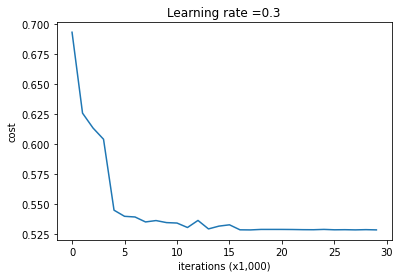

{'W1': array([[ 1.29049178,  2.73370465],
       [ 1.06393949, -2.0118256 ],
       [-3.03763257,  0.36714822],
       [ 1.76403605, -1.367684  ]]), 'b1': array([[-0.16169655],
       [ 0.73429285],
       [-0.67486356],
       [-1.05338505]]), 'W2': array([[ 0.89606886, -0.1019959 ,  0.58374679,  2.45662296],
       [ 1.63137347,  1.76787273,  2.13454421, -0.40223932],
       [-0.38562772, -1.09465293,  0.17624251, -0.78336914]]), 'b2': array([[-2.43633123],
       [-5.33883999],
       [-0.61803194]]), 'W3': array([[-3.05212404, -2.98176316,  1.18845769]]), 'b3': array([[0.78119474]])}


In [104]:
parameters = model(X, Y)
print(parameters)

Cost after iteration 0: 0.6934189762057819
Cost after iteration 10000: 0.5158351307450819
Cost after iteration 20000: 0.5136163237581202


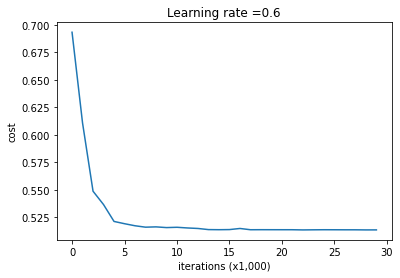

In [99]:
parameters = model(X,Y,learning_rate=0.6 , keep_prob=0.86)

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error 
print(X.shape , Y.shape)
x_train , x_test , y_train ,y_test = train_test_split(X.T,Y.T , random_state =42)

(2, 1500) (1, 1500)


In [111]:
x_train.shape , x_test.shape

((1125, 2), (375, 2))

In [115]:
x_train , x_test = x_train.T ,x_test.T
y_train, y_test = y_train.T , y_test.T
print(x_train.shape , y_train.shape)
print(x_test.shape , y_test.shape)

(1125, 2) (1125, 1)
(375, 2) (375, 1)


Cost after iteration 0: 0.6872244667073059
Cost after iteration 10000: 0.5871571373109217
Cost after iteration 20000: 0.5880665818805688


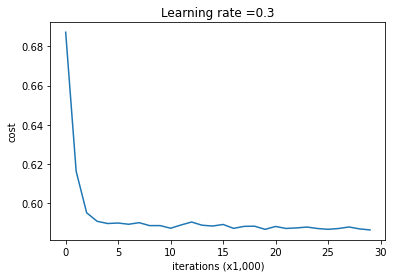

In [136]:
parameters = model(x_train.T , y_train.T)